### Autofocus and auto-ETL functions study for mesoSPIM 

Key points:
* sharpness metric: normalized DCT Shannon Entropy [(Royer at al 2016)](https://doi.org/10.1038/nbt.3708) and https://github.com/MicroscopeAutoPilot/AutoPilot.
Initial state can be far from optimal, so the optimization algo using grid search and Gaussian fitting proposed by Royer et al. may not be optimal in terms of speed. But it may be more robust against noise and easier to implement than gradient-climbing algos.

Other optimization algo candidates: Fibonacci and Golden ratio search also require known interval \[a,b\] where to search, but they are not popular for AF because they require a lot of motion reversals (mechanically non-optimal).

### Defocus function
Gaussian kernel with std $r(z)$ follows [(Royer at al 2016, SI, p. 15)](https://doi.org/10.1038/nbt.3708)
$$r(z) = r_0\sqrt{1 + (z/z_r)^2}$$
- $z$ is the defocus distance,
- $r_0 = \frac{\lambda}{\pi NA}$ is the in-focus PSF standard deviation (Gaussian beam approximation), 
- $z_r = \frac{\pi r_0^2}{\lambda}$ is the Raleigh length of the focal volume, 
- $NA$ is the detection numerical aperture.

Note: mesoSPIM NA varies from 0.075 (zoom 1x) to 0.22 (zoom 4x) (lens MVX-10/MVPLAPO) (source: mesoSPIM SI, p.49)

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import tifffile as tif
import sys
import os
import time

In [2]:
utils_path = '../../../mesoSPIM/src/'
if os.path.exists(utils_path):
    sys.path.append('../../../mesoSPIM/src/')
else:
    print('Error: check your path to utils module')

In [3]:
from utils import optimization as opt

In [56]:
# iDisco mouse brain from Anna-Maria Reuss
img_folder = '../fixtures/defocus/'
exp_files = {'left_488': 'zstep1_Fstep10_488_nm_1x_Left_crop400',
              'right_488': 'zstep1_Fstep10_488_nm_1x_Right_crop400',
              'left_561': 'zstep1_Fstep10_561_nm_1x_Left_crop400',
              'right_561': 'zstep1_Fstep10_561_nm_1x_Right_crop400',
            }

In [41]:
stack = tif.imread(img_folder + exp_files['left_488'] + '.tif')

Text(0.5, 1.0, 'Image off the focus (+200 um)')

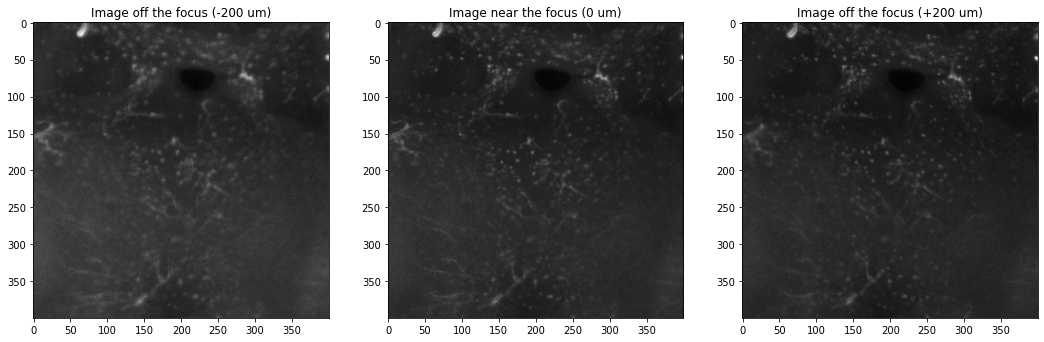

In [61]:
plt.figure(figsize=(18,6))
plt.subplot(1, 3, 1)
plt.imshow(stack[0,:,:], cmap='gray')
plt.title("Image off the focus (-200 um)")

plt.subplot(1, 3, 2)
plt.imshow(stack[10,:,:], cmap='gray')
plt.title("Image near the focus (0 um)")

plt.subplot(1, 3, 3)
plt.imshow(stack[-1,:,:], cmap='gray')
plt.title("Image off the focus (+200 um)")

In [58]:
%%time
expt_dcts = {}
for key in exp_files:
    stack = tif.imread(img_folder + exp_files[key] + '.tif')
    expt_dcts[key] = []
    for z in range(stack.shape[0]):
        expt_dcts[key].append(opt.shannon_dct(stack[z,:,:]))

Wall time: 357 ms


In [62]:
%%timeit
opt.shannon_dct(stack[20,:,:])

2.67 ms ± 134 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Text(0, 0.5, 'DCTS, a.u.')

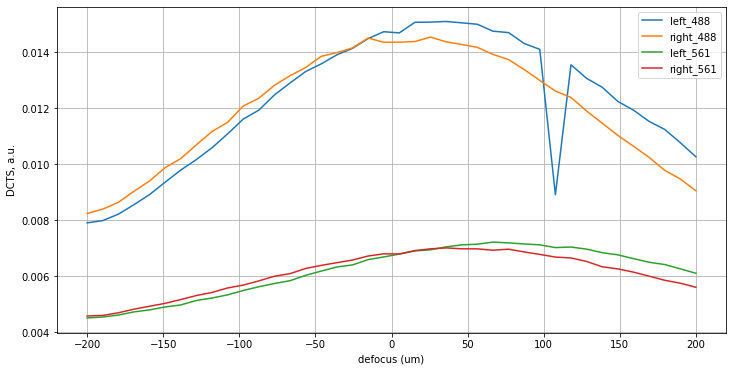

In [59]:
plt.figure(figsize=(12,6))
defocus_um = np.linspace(-200, 200, stack.shape[0])
for key in expt_dcts:
    plt.plot(defocus_um, expt_dcts[key], label=key)
plt.grid(True)
plt.legend()
plt.xlabel('defocus (um)')
plt.ylabel('DCTS, a.u.')

### Things to note
- DCTS gives a decent dynamic range on this data. This does not mean it is calculated mathematically correctly, but good enough for practical purposes.
- DCTS is calculated fast: for 400x400px images, it takes ~3 ms/image.
- The eye-balled focus position $z=0$ is off by about 10 um from true shapness maximum (using right 488 ch)
- Although the system is aligned (left vs right arm), there is a noticeable difference in focus between arms, about 30 um. It is very difficult if not impossible to spot this difference by eye, looking at the raw image.
- The z-stage (Galil) made a hickup when moving through left-488 stack.
- due to noise and possible stage hickups, a grid search with interpolation (following Royer et al, 2016) is probably the safest way to proceed.

In [96]:
# def fit_gaussian_1d(f_arr, x_arr):
#     """Fit measured values f_arr(x_arr) with a gaussian function.
    
#     Parameters:
#     -----------
#     f_arr: 1d-array
#         Measured function values.
#     x_arr: 1d-array
#         Positions where the function was measured.
        
#     Returns:
#     --------
#     (xcenter, sigma, f_amp, f_offset): tuple
#         Parameters of gaussian function fit: `f = f_offset + f_amp * np.exp(- ((x_arr - xcenter) ** 2) / (2 * sigma ** 2))`
#     """
#     assert len(f_arr.shape) == len(x_arr.shape) == 1, f"Arrays must be 1d, got {f_arr.shape}, {x_arr.shape} instead"
#     if len(x_arr) < 4:
#         print(f"Warning: fitting 4 parameters with {len(x_arr)} data points, under-constrained.")
#     x_peak = x_arr[np.argmax(f_arr)] # initial guess for gaussian peak position
#     sigma_guess, amp_guess = x_arr.std(), f_arr.max()
#     initial_guess = (x_peak, sigma_guess, amp_guess, amp_guess/10) # Parameters: xpos, sigma, amp, offset
#     try:
#         popt, pcov = scipy.optimize.curve_fit(opt._gaussian_1d, (x_arr), f_arr, 
#                                               p0=initial_guess, 
#                                               bounds=((x_arr.min(), # min position of the gaussian peak, must be within x-argument bounds
#                                             0.2 * sigma_guess,  # min sigma
#                                             0.5 * amp_guess, 0.001 * amp_guess),  # min amp, min offset
#                                            (x_arr.max(), # max position of the gaussian peak, must be within x-argument bounds
#                                             20 * sigma_guess,  # max sigma
#                                             3 * amp_guess, 0.5 * amp_guess)))  # max amp, offset
#     except RuntimeError as e:
#         popt = initial_guess
#         print(f"{e}")
#     xcenter, sigma, f_amp, f_offset = popt
#     return xcenter, sigma, f_amp, f_offset

### Test fit_gaussian_1d()

c:\users\nikita\anaconda3\envs\py36\lib\site-packages\scipy\optimize\minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
c:\users\nikita\anaconda3\envs\py36\lib\site-packages\scipy\optimize\minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
c:\users\nikita\anaconda3\envs\py36\lib\site-packages\scipy\optimize\minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Optimal parameters not found: The maximum number of function evaluations is exceeded.


c:\users\nikita\anaconda3\envs\py36\lib\site-packages\scipy\optimize\minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
c:\users\nikita\anaconda3\envs\py36\lib\site-packages\scipy\optimize\minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.


c:\users\nikita\anaconda3\envs\py36\lib\site-packages\scipy\optimize\minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
c:\users\nikita\anaconda3\envs\py36\lib\site-packages\scipy\optimize\minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
c:\users\nikita\anaconda3\envs\py36\lib\site-packages\scipy\optimize\minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Optimal parameters not found: The maximum number of function evaluations is exceeded.


c:\users\nikita\anaconda3\envs\py36\lib\site-packages\scipy\optimize\minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Optimal parameters not found: The maximum number of function evaluations is exceeded.


c:\users\nikita\anaconda3\envs\py36\lib\site-packages\scipy\optimize\minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Optimal parameters not found: The maximum number of function evaluations is exceeded.


c:\users\nikita\anaconda3\envs\py36\lib\site-packages\scipy\optimize\minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Optimal parameters not found: The maximum number of function evaluations is exceeded.


c:\users\nikita\anaconda3\envs\py36\lib\site-packages\scipy\optimize\minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
c:\users\nikita\anaconda3\envs\py36\lib\site-packages\scipy\optimize\minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.


c:\users\nikita\anaconda3\envs\py36\lib\site-packages\scipy\optimize\minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Optimal parameters not found: The maximum number of function evaluations is exceeded.


c:\users\nikita\anaconda3\envs\py36\lib\site-packages\scipy\optimize\minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.


c:\users\nikita\anaconda3\envs\py36\lib\site-packages\scipy\optimize\minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Optimal parameters not found: The maximum number of function evaluations is exceeded.


c:\users\nikita\anaconda3\envs\py36\lib\site-packages\scipy\optimize\minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
c:\users\nikita\anaconda3\envs\py36\lib\site-packages\scipy\optimize\minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
c:\users\nikita\anaconda3\envs\py36\lib\site-packages\scipy\optimize\minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
c:\users\nikita\anaconda3\envs\py36\lib\site-packages\scipy\optimize\minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
c:\users\nikita\anaconda3\envs\py36\lib\site-packages\scipy\optimize\minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
c:\users\nikita\anaconda3\envs\py36\lib\site-packages\scipy\optimize\minpack.py:787: Optim

Optimal parameters not found: The maximum number of function evaluations is exceeded.


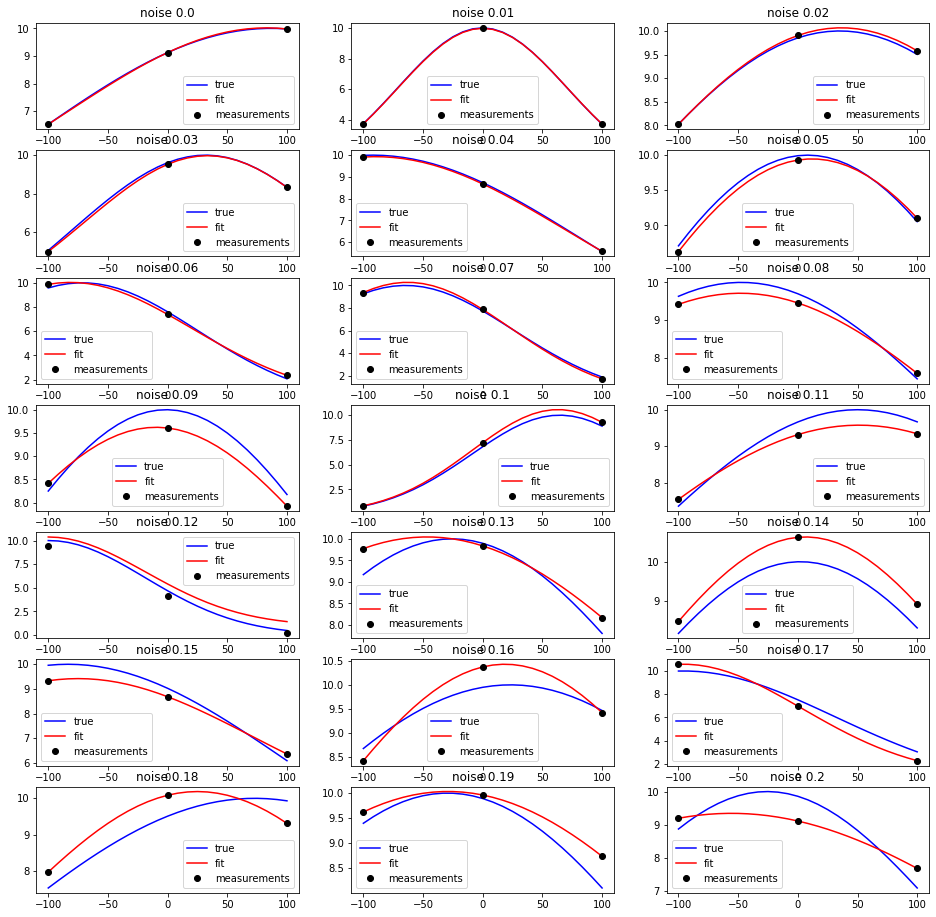

In [89]:
x_min, x_max = -100, 100
n_points = 3
x_points = np.linspace(x_min, x_max, n_points)
true_amp = 10
min_sigma = (x_max - x_min) / n_points # sigma should not be much smaller that sampling step
n_reps = 30
errors_center_sigma = []
noise_range = np.linspace(0, 0.2, 21)
show_cases = True
if show_cases:
    x_grid = np.linspace(x_min, x_max, 25)
    fig = plt.figure(figsize=(16, 16))
    
for i_noise, noise_ratio in enumerate(noise_range):
    sum_err_center, sum_err_sigma = 0, 0
    for irep in range(n_reps):
        true_center = np.random.rand() * (x_points.max() - x_points.min()) + x_points.min()
        true_sigma = min_sigma + np.random.rand() * (x_max - x_min) 
        noise = (np.random.rand(n_points) - 0.5) * true_amp * noise_ratio

        f_points_ideal = opt._gaussian_1d(x_points, true_center, true_sigma, amplitude=true_amp) 
        f_points = f_points_ideal + noise
        fit_center, fit_sigma, fit_amp, fit_offset = opt.fit_gaussian_1d(f_points, x_points)
        
        if show_cases and irep == 1:
            ax = fig.add_subplot(7, 3, i_noise+1)
            ax.plot(x_grid, opt._gaussian_1d(x_grid, true_center, true_sigma, true_amp, 0), "-b", label="true")
            ax.plot(x_grid, opt._gaussian_1d(x_grid, fit_center, fit_sigma, fit_amp, fit_offset), "-r", label="fit")
            ax.plot(x_points, f_points, "ko", label="measurements")
            ax.set_title(f"noise {noise_ratio}")
            ax.legend()
            #print(f"diff in center: {fit_center - true_xcenter}, in sigma: {fit_sigma - true_sigma}")
        
        sum_err_center += fit_center - true_center
        sum_err_sigma   += fit_sigma - true_sigma
        
    errors_center_sigma.append((sum_err_center/n_reps, sum_err_sigma/n_reps))

Text(0, 0.5, 'Error, a.u. (e.g. microns)')

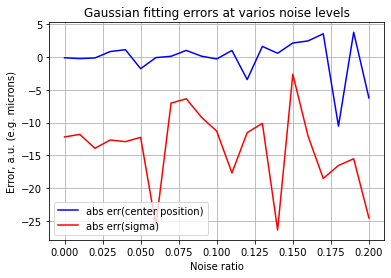

In [90]:
errors_center_sigma = np.array(errors_center_sigma)
plt.plot(noise_range, errors_center_sigma[:,0], "-b", label="abs err(center position)")
plt.plot(noise_range, errors_center_sigma[:,1], "-r", label="abs err(sigma)")
plt.legend()
plt.grid(True)
plt.title("Gaussian fitting errors at varios noise levels")
plt.xlabel("Noise ratio")
plt.ylabel("Error, a.u. (e.g. microns)")

### Notes on 1d gaussian fitting
- at least 3 points are needed to fit a 1d gaussian, ideally 5, because it has 4 free parameters.
- the gaussian center is fitted quite accurately, with error $ < 5 \mu m$ (x-values spanning 200 um)
- the gaussian center must lie within the measured range, between $x_{min}$ and $x_{max}$
- the gaussian sigma is fitted less accurately, ~$15 \mu m$ with bias toward under-estimation.
- fitting remains stable with noise levels up to $0.2$, which is quite good.

## Parabolic fitting
Parabolic fitting requires only 3 parameters: $f(x) = a (x-x_0)^2 + b$

c:\users\nikita\anaconda3\envs\py36\lib\site-packages\scipy\optimize\minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
c:\users\nikita\anaconda3\envs\py36\lib\site-packages\scipy\optimize\minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
c:\users\nikita\anaconda3\envs\py36\lib\site-packages\scipy\optimize\minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
c:\users\nikita\anaconda3\envs\py36\lib\site-packages\scipy\optimize\minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
c:\users\nikita\anaconda3\envs\py36\lib\site-packages\scipy\optimize\minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
c:\users\nikita\anaconda3\envs\py36\lib\site-packages\scipy\optimize\minpack.py:787: Optim

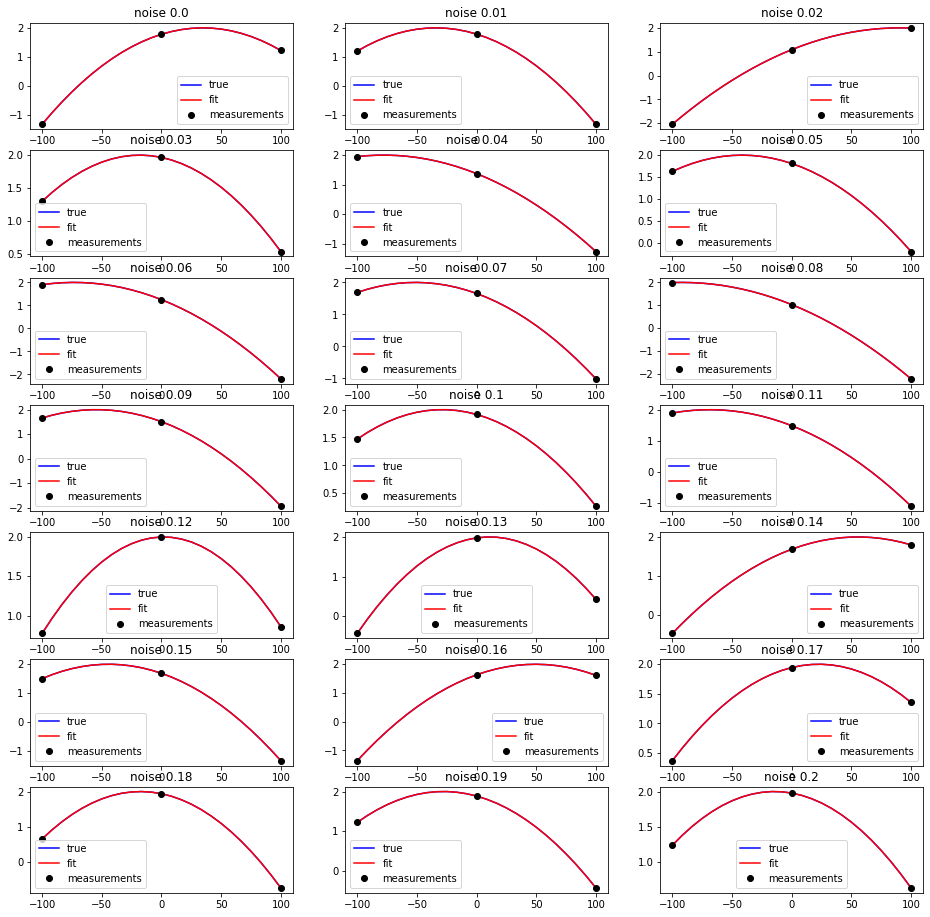

In [47]:
min_amp = 1e-4
amp_scale = 0.0001
true_offset = 2
errors_center_amp = []
show_cases = True
if show_cases:
    x_grid = np.linspace(x_min, x_max, 25)
    fig = plt.figure(figsize=(16, 16))
    
for i_noise, noise_ratio in enumerate(noise_range):
    sum_err_center, sum_err_amp = 0, 0
    for irep in range(n_reps):
        true_center = np.random.rand() * (x_points.max() - x_points.min()) + x_points.min()
        true_amp = min_amp + amp_scale * np.random.rand()
        noise = (np.random.rand(n_points) - 0.5) * true_amp * noise_ratio

        f_points_ideal = opt._parabola_1d(x_points, true_center, true_amp, true_offset) 
        f_points = f_points_ideal + noise
        fit_center, fit_amp, fit_offset = opt.fit_parabola_1d(f_points, x_points)
        
        if show_cases and irep == 1:
            ax = fig.add_subplot(7, 3, i_noise+1)
            ax.plot(x_grid, opt._parabola_1d(x_grid, true_center,  true_amp, true_offset), "-b", label="true")
            ax.plot(x_grid, opt._parabola_1d(x_grid, fit_center, fit_amp, fit_offset), "-r", label="fit")
            ax.plot(x_points, f_points, "ko", label="measurements")
            ax.set_title(f"noise {noise_ratio}")
            ax.legend()
            #print(f"diff in center: {fit_center - true_xcenter}, in sigma: {fit_sigma - true_sigma}")
        
        sum_err_center += fit_center - true_center
        sum_err_amp   += fit_amp - true_amp
        
    errors_center_amp.append((sum_err_center/n_reps, sum_err_amp/n_reps))
    
errors_center_amp = np.array(errors_center_amp)

In [48]:
f_points, x_points

(array([0.96824238, 1.96942891, 0.13568728]), array([-100.,    0.,  100.]))

In [49]:
x_arr = x_points
f_arr = f_points
x_peak = x_arr[np.argmax(f_arr)]  # initial guess for peak position
amp_guess, offset_guess = f_arr.max()/((x_arr.max() - x_arr.min()) / 2)**2, f_arr.max()
initial_guess = (x_peak, amp_guess, offset_guess)  # Parameters: xpos, amp, offset
initial_guess

(0.0, 0.0001969428908444328, 1.969428908444328)

In [46]:
true_center, true_amp, true_offset

(49.1912683235536, 0.001016387696684305, 2)

Text(0, 0.5, 'Error, a.u. (e.g. microns)')

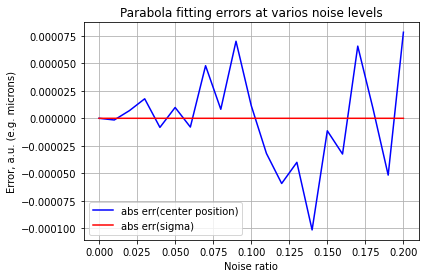

In [51]:
plt.plot(noise_range, errors_center_amp[:,0], "-b", label="abs err(center position)")
plt.plot(noise_range, errors_center_amp[:,1], "-r", label="abs err(sigma)")
plt.legend()
plt.grid(True)
plt.title("Parabola fitting errors at varios noise levels")
plt.xlabel("Noise ratio")
plt.ylabel("Error, a.u. (e.g. microns)")

## Notes on parabolic fitting
- 3 points are sufficient for virtually error-free fitting, if the true underlying function is parabola.

## What if the true underlying function is e.g. gaussian?

c:\users\nikita\anaconda3\envs\py36\lib\site-packages\scipy\optimize\minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
c:\users\nikita\anaconda3\envs\py36\lib\site-packages\scipy\optimize\minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
c:\users\nikita\anaconda3\envs\py36\lib\site-packages\scipy\optimize\minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
c:\users\nikita\anaconda3\envs\py36\lib\site-packages\scipy\optimize\minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
c:\users\nikita\anaconda3\envs\py36\lib\site-packages\scipy\optimize\minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
c:\users\nikita\anaconda3\envs\py36\lib\site-packages\scipy\optimize\minpack.py:787: Optim

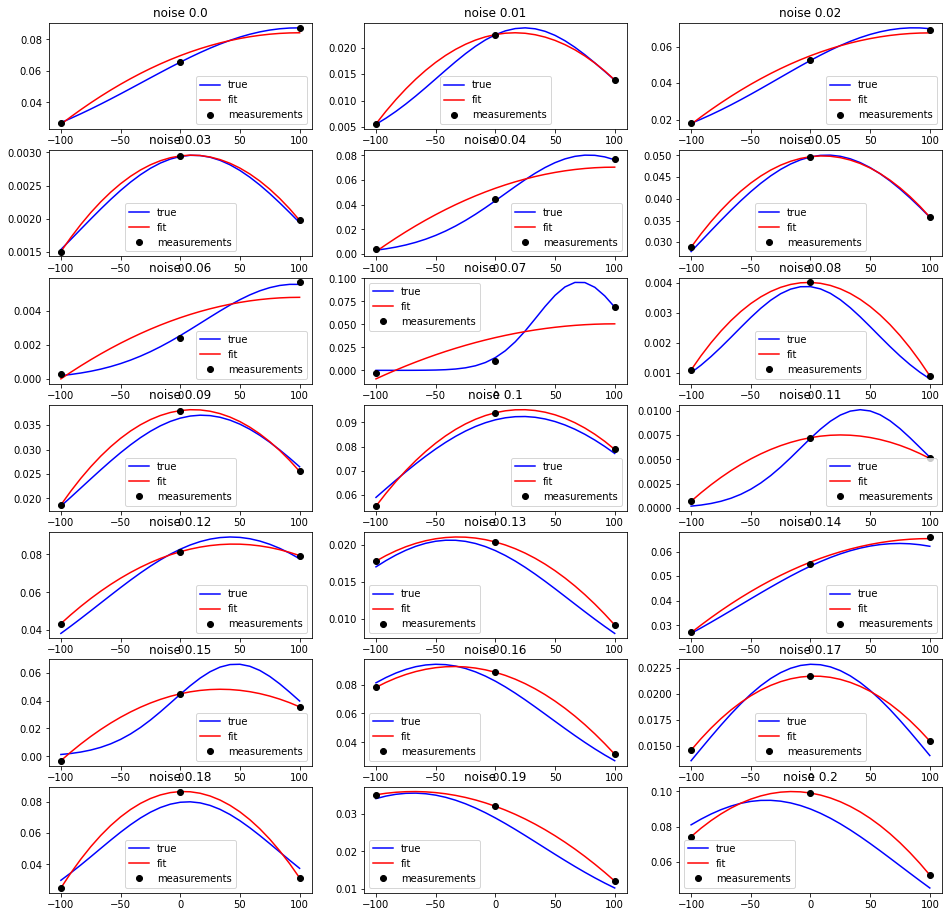

In [54]:
min_amp = 1e-4
amp_scale = 0.1
true_offset = 2
sigma_scale = 0.5
min_sigma = (x_max - x_min) / n_points / 2 # sigma should not be much smaller that sampling step
errors_center_amp = []
show_cases = True
if show_cases:
    x_grid = np.linspace(x_min, x_max, 25)
    fig = plt.figure(figsize=(16, 16))
    
for i_noise, noise_ratio in enumerate(noise_range):
    sum_err_center, sum_err_amp = 0, 0
    for irep in range(n_reps):
        true_center = np.random.rand() * (x_points.max() - x_points.min()) + x_points.min()
        true_amp = min_amp + amp_scale * np.random.rand()
        true_sigma = min_sigma + sigma_scale * np.random.rand() * (x_max - x_min) 
        noise = (np.random.rand(n_points) - 0.5) * true_amp * noise_ratio

        f_points_ideal = opt._gaussian_1d(x_points, true_center, true_sigma, true_amp) 
        f_points = f_points_ideal + noise
        fit_center, fit_amp, fit_offset = opt.fit_parabola_1d(f_points, x_points)
        
        if show_cases and irep == 1:
            ax = fig.add_subplot(7, 3, i_noise+1)
            ax.plot(x_grid, opt._gaussian_1d(x_grid, true_center, true_sigma, true_amp), "-b", label="true")
            ax.plot(x_grid, opt._parabola_1d(x_grid, fit_center, fit_amp, fit_offset), "-r", label="fit")
            ax.plot(x_points, f_points, "ko", label="measurements")
            ax.set_title(f"noise {noise_ratio}")
            ax.legend()
            #print(f"diff in center: {fit_center - true_xcenter}, in sigma: {fit_sigma - true_sigma}")
        
        sum_err_center += fit_center - true_center
        sum_err_amp   += fit_amp - true_amp
        
    errors_center_amp.append((sum_err_center/n_reps, sum_err_amp/n_reps))
    
errors_center_amp = np.array(errors_center_amp)

Text(0, 0.5, 'Error, a.u. (e.g. microns)')

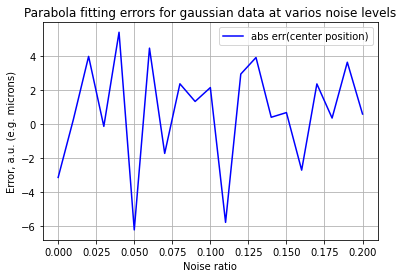

In [55]:
plt.plot(noise_range, errors_center_amp[:,0], "-b", label="abs err(center position)")
plt.legend()
plt.grid(True)
plt.title("Parabola fitting errors for gaussian data at varios noise levels")
plt.xlabel("Noise ratio")
plt.ylabel("Error, a.u. (e.g. microns)")

## Check fitting against the experimental data

c:\users\nikita\anaconda3\envs\py36\lib\site-packages\scipy\optimize\minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
c:\users\nikita\anaconda3\envs\py36\lib\site-packages\scipy\optimize\minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
c:\users\nikita\anaconda3\envs\py36\lib\site-packages\scipy\optimize\minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
c:\users\nikita\anaconda3\envs\py36\lib\site-packages\scipy\optimize\minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


<Figure size 864x432 with 0 Axes>

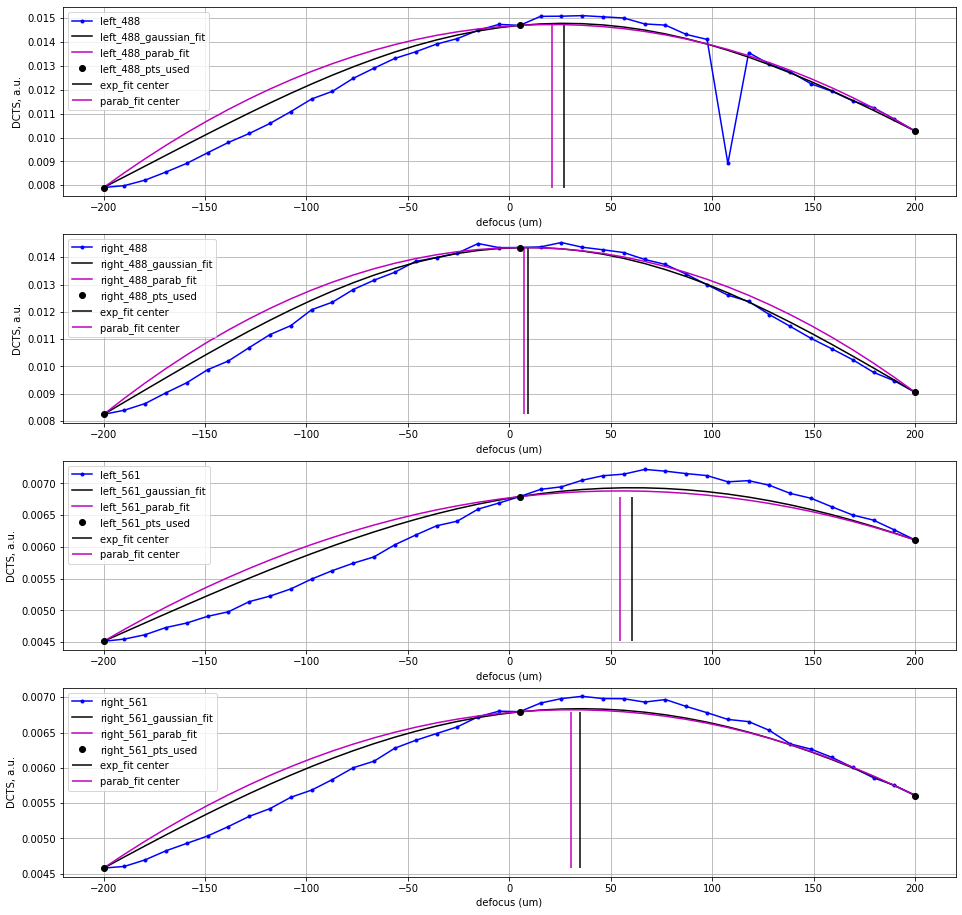

In [88]:
plt.figure(figsize=(12,6))
defocus_um = np.linspace(-200, 200, stack.shape[0])
ind_consider = [0, 20, -1]
x_points = defocus_um[ind_consider]

fig = plt.figure(figsize=(16, 16))
for ik, key in enumerate(expt_dcts):
    f_points = np.array(expt_dcts[key])[ind_consider]
    fit_center, fit_sigma, fit_amp, fit_offset = opt.fit_gaussian_1d(f_points, x_points)
    parab_fit_center, parab_fit_amp, parab_fit_offset = opt.fit_parabola_1d(f_points, x_points)
    
    ax = fig.add_subplot(len(expt_dcts), 1, ik+1)
    ax.plot(defocus_um, expt_dcts[key], '.-b', label=key)
    ax.plot(defocus_um, opt._gaussian_1d(defocus_um, fit_center, fit_sigma, fit_amp, fit_offset), 'k', 
            label=key + "_gaussian_fit",)
    ax.plot(defocus_um, opt._parabola_1d(defocus_um, parab_fit_center, parab_fit_amp, parab_fit_offset), 'm', 
            label=key + "_parab_fit",)
    ax.plot(x_points, f_points, 'ko', label=key + "_pts_used",)
    ax.vlines(fit_center, f_points.min(), f_points.max(), 'k', label="exp_fit center")
    ax.vlines(parab_fit_center, f_points.min(), f_points.max(), 'm', label="parab_fit center")
    
    ax.grid(True)
    ax.legend(loc='upper left')
    ax.set_xlabel('defocus (um)')
    ax.set_ylabel('DCTS, a.u.')

## Conclusions so far
- both exponential and parabolic fits are quite accurate and agree with each other in terms of center location;
- parabolic is best with very few measurements (3 points are totally OK), while gaussian can be more accurate with higher number of points, especially if the underlying function is gaussian (such as defocus).
- the center should lie within the boundaries of measuring points, and these points should not be too far from each other. A step size on the order of sigma or less seems to be a good rule of thumb. A 200 um seems to be a good guess for given experiment (low NA~0.1 imaging).